# Lesson 1 Demo — From Regression to Deep Learning

This notebook mirrors the Lesson 1 slides: generate a non-linear 2D dataset,
train a small PyTorch model, and visualize decision regions.

## Setup
If packages are missing, uncomment the pip installs.

In [1]:
# !pip install -q torch matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


## Make a 2D dataset
We use `make_circles` if available; otherwise a lightweight spiral generator.

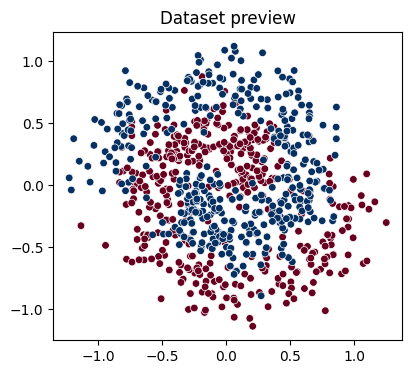

In [3]:
def make_spiral(n=500, noise=0.2, seed=0):
    rng = np.random.default_rng(seed)
    n2 = n // 2
    t = np.linspace(0, 2*np.pi, n2)
    r = np.linspace(0.2, 1.0, n2)
    x1 = np.c_[r*np.cos(t), r*np.sin(t)] + noise * rng.standard_normal((n2, 2))
    x2 = np.c_[-r*np.cos(t), -r*np.sin(t)] + noise * rng.standard_normal((n2, 2))
    Xs = np.vstack([x1, x2]).astype('float32')
    ys = np.r_[np.zeros(n2), np.ones(n2)].astype('float32')
    return Xs, ys

X, y = make_spiral(n=800, noise=0.15, seed=0)

plt.figure(figsize=(4.5,4))
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', s=30, edgecolor='white', linewidth=0.5)
plt.title('Dataset preview')
plt.show()


## Build and train a small network
Two hidden layers with ReLU and a sigmoid output for binary classification.

In [4]:
idx = np.arange(len(X))
np.random.shuffle(idx)
split = int(0.8 * len(X))
train_idx, val_idx = idx[:split], idx[split:]
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]


In [12]:
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train).unsqueeze(1)
X_val_t = torch.from_numpy(X_val)
y_val_t = torch.from_numpy(y_val).unsqueeze(1)

In [13]:
model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid(),
)

In [14]:
model

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
  (5): Sigmoid()
)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

train_losses = []
val_losses = []

for epoch in range(2000):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_t)
    loss = loss_fn(preds, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t)
        val_loss = loss_fn(val_preds, y_val_t)
        val_losses.append(val_loss.item())

model.eval()
with torch.no_grad():
    val_probs = model(X_val_t)
    val_pred_labels = (val_probs > 0.5).float()
    val_acc = (val_pred_labels.eq(y_val_t)).float().mean().item()
float(val_acc)


0.831250011920929

## Training and validation loss
Track how the model improves over epochs.


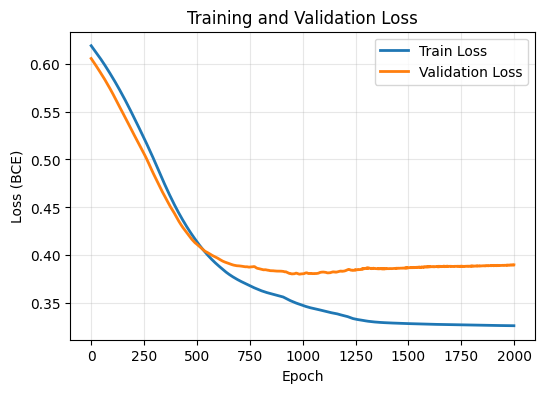

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Plot decision regions
Compare model predictions across a mesh grid with the data points.

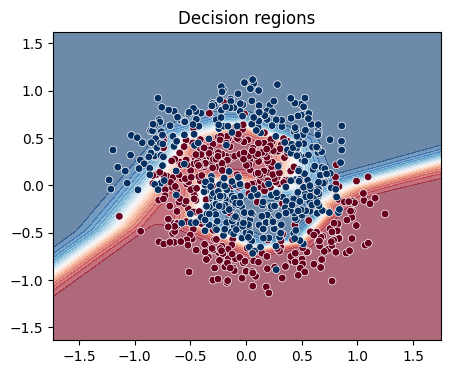

In [21]:
xx, yy = np.meshgrid(
    np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200),
    np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()].astype('float32')
model.eval()
with torch.no_grad():
    grid_t = torch.from_numpy(grid)
    probs = model(grid_t).detach().numpy().reshape(xx.shape)

plt.figure(figsize=(5,4))
cs = plt.contourf(xx, yy, probs, levels=20, cmap='RdBu', alpha=0.6)
plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', edgecolor='white', linewidth=0.5, s=30)
plt.title('Decision regions')
plt.show()
